In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from PIL import Image
import pickle as pickle 

In [2]:
def stepFunc(x):
    return np.array(x>0, dtype=np.int)

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def reLU(x):
    return np.maximum(0,x)

In [5]:
# tanh = sinh(x)/cosh(x)
def tanh(x):
    # tanh
    #return (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))
    # (tanh + 1) / 2 这样结果区间 就在0～1之间了，和其他函数一致 （*eLU 除外）
    # return np.exp(x)/(np.exp(x)+np.exp(-x))
    # (tanh + 1) / 2 化简一下 就和  sigmoid 
    # 1 / (1 + np.exp(-x)) = 1 / (1 + np.exp(-x))
    return 1 / (1 + np.exp( - 2 * x))

In [6]:
def eLU(x, a = 1):
    return [x1 if x1>0 else a *(np.exp(x1)-1) for x1 in x ]
    #y = x.copy()
    #y[x<0] = a *(np.exp(y[x<0])-1)
    #return y

In [7]:
def pReLU(x, a=0.1):
    return np.maximum(a*x, x)

In [8]:
def plotFunc():
    x = np.arange(-5.0, 5.0, 0.5)
    fig = plt.figure()
    ax = fig.add_subplot(321)
    ax.plot(x,stepFunc(x))
    ax.text(-4.9,0.7,'step function')
    ax = fig.add_subplot(322)
    ax.plot(x,sigmoid(x), c='red')
    ax.text(-4.9,0.7,'sigmoid')
    ax = fig.add_subplot(323)
    ax.plot(x,eLU(x), c='black')
    ax.text(-4.9,4,'ELU')
    ax = fig.add_subplot(324)
    ax.plot(x,reLU(x), c='green')
    ax.text(-4.9,4,'ReLU')
    ax = fig.add_subplot(325)
    ax.plot(x,tanh(x), c='blue')
    ax.text(-4.9,0.7,'tanh')
    ax = fig.add_subplot(326)
    ax.plot(x,pReLU(x), c='pink')
    ax.text(-4.9,4,'PReLU')
    plt.show()

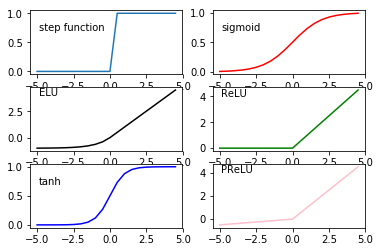

In [9]:
plotFunc()

In [10]:
#恒等函数
def identifyFunc(x):
    return x

In [11]:
def initNetwork():
    W = []; B = []
    W.append(np.array([[0.1,0.3,0.5],[0.2,0.4,0.6]]))
    B.append(np.array([0.1,0.2,0.3]))
    W.append(np.array([[0.1,0.4],[0.2,0.5],[0.3,0.6]]))
    B.append(np.array([0.1,0.2]))
    W.append(np.array([[0.1,0.3],[0.2,0.4]]))
    B.append(np.array([0.1,0.2]))
    return W, B, 3

In [12]:
def calcLayer(A, w, b, h=sigmoid):
    return h(np.dot(A,w) + b)

In [13]:
def forward(network, x, h=sigmoid, sigma = identifyFunc ):
    W, B, l = network
    A = x
    for i in range(l-1):
        A = calcLayer(A, W[i], B[i], h)
    return calcLayer(A, W[l-1], B[l-1], sigma)

In [14]:
network = initNetwork()
x = np.array([1.0,0.5])
forward(network,x)

array([0.31682708, 0.69627909])

In [15]:
def softmax(x):
    c = np.max(x)
    expA = np.exp(x - c)
    return expA / np.sum(expA)

In [16]:
forward(network,x,sigma = softmax)

array([0.40625907, 0.59374093])

In [17]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [18]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

In [19]:
img = x_train[0]
img = img.reshape(28, 28)  # 把图像的形状变为原来的尺寸
img_show(img)

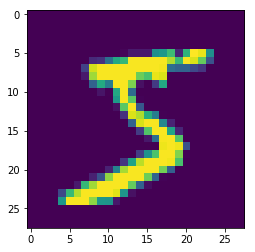

In [20]:
plt.imshow(img)
plt.show()

In [21]:
def get_data(zgh = True):
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize = zgh, flatten=True, one_hot_label=False)
    return x_test, t_test

In [22]:
def load_network():
    with open("ch03_weight.obj", 'rb') as f:
        network = pickle.load(f)
    return network

In [23]:
def predict(network, x , h = sigmoid, sigma = identifyFunc ):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = calcLayer(x, W1, b1, h)
    a2 = calcLayer(a1, W2, b2, h )
    y  = calcLayer(a2, W3, b3, sigma )
    
    return y

In [24]:
x, t = get_data(True)
network = load_network()

In [25]:
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i], h = sigmoid , sigma = identifyFunc  )
    p = np.argmax(y) # 获取概率最高的元素的索引
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy: %.2f%%" %(float(accuracy_cnt) / len(x) * 100))

Accuracy: 93.52%


In [26]:
# 这个式common 中的代码， 在批处理中  y_batch.ndim == 2
# 但是这个是否不影响 运行的结果
def softmax2dim(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        expX = np.exp(x)
        y = expX / np.sum(expX, axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    expX = np.exp(x)
    return expX / np.sum(expX)

In [27]:
batch_size = 100 # 批数量
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch, sigma = softmax2dim )
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy: %.2f%%" %(float(accuracy_cnt) / len(x) * 100))


Accuracy: 93.52%


In [28]:
#  针对训练数据测试一下，看看有什么差别
(x, t), _ = load_mnist(normalize = True, flatten=True, one_hot_label=False)
batch_size = 100 # 批数量
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch, sigma = softmax2dim )
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy: %.2f%%" %(float(accuracy_cnt) / len(x) * 100))

Accuracy: 93.58%
